In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ipynb.fs.full.util import get_one
from ipynb.fs.full.util import load_candidates
from ipynb.fs.full.util import to_X_y

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import LinearSVC

In [2]:
df_result = pd.read_csv("../data/dataset_cleaned.csv", na_values=["_NULL_"], keep_default_na=False)
df_metamap = pd.read_csv("../data/metamap.csv", na_values=["_NULL_"], keep_default_na=False)

df = pd.merge(df_result, df_metamap, how="inner", on=["test_key", "result_key"])

In [3]:
df_organism_genus = df[
    df["level_1"].notna()
    & (df["level_1"] != "*not in hierarchy")
    & (df["level_1"] != "*not in scope")
]

display(df_organism_genus.shape)

(38370, 16)

In [4]:
df_organism_species = df[
    df["level_1"].notna()
    & (df["level_1"] != "*not in hierarchy")
    & (df["level_1"] != "*not in scope")
    & df["level_2"].notna()
]

display(df_organism_species.shape)

(38370, 16)

In [5]:
# =====================================
# train a classifier for Organism Genus

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=1)
X, y, _ = to_X_y(vectorizer, df_organism_genus, "level_1")

classifier = LinearSVC(random_state=1731, max_iter=10000)
classifier.fit(X, y)

C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=1731, tol=0.0001,
     verbose=0)

In [6]:
# =============================
# train the symbolic classifier

dictionary = {}

for _, row in df_organism_species.iterrows():
    raw_genus_label = row["level_1"]
    if raw_genus_label == "influzena":
        raw_genus_label = "influenza"
    genus_labels = raw_genus_label.split(" or ")
    
    species_label = row["level_2"]
    
    if raw_genus_label not in dictionary:
        dictionary[raw_genus_label] = set()
    dictionary[raw_genus_label].add(species_label)
    
    for genus_label in genus_labels:
        if genus_label not in dictionary:
            dictionary[genus_label] = set()
        dictionary[genus_label].add(species_label)

display(dictionary)

{'*not found': {'*not found'},
 'influenza': {'flu a', 'flu b', 'generic flu virus'},
 'yersinia': {'yersinia bercovieri',
  'yersinia enterocolitica',
  'yersinia frederiksenii',
  'yersinia intermedia',
  'yersinia kristensenii',
  'yersinia massiliensis',
  'yersinia mollaretii',
  'yersinia pseudotuberculosis',
  'yersinia rohdei',
  'yersinia species'},
 'clostridium': {'clostridium aldenense',
  'clostridium algidicarnis',
  'clostridium bifermentans',
  'clostridium bolteae',
  'clostridium botulinum',
  'clostridium butyricum',
  'clostridium cadaveris',
  'clostridium celerecrescens',
  'clostridium citroniae',
  'clostridium clostridioforme',
  'clostridium difficile',
  'clostridium disporicum',
  'clostridium frigidicarnis',
  'clostridium glycolicum',
  'clostridium hastiforme',
  'clostridium hathewayi',
  'clostridium hylemonae',
  'clostridium innocuum',
  'clostridium jejuense',
  'clostridium limosum',
  'clostridium mangenotii',
  'clostridium novyi',
  'clostridium 

In [7]:
# =======================
# classify the given data

def classify_row(row):
    document = row["result_full_description"]
    X_test = vectorizer.transform([document])
    level_1_pred = classifier.predict(X_test)[0]
    
    if level_1_pred == "*not found":
        return "*not found"
    
    if level_1_pred not in dictionary:
        return "*no further diff"
    
    candidates = load_candidates(row["candidates"])
    if not candidates:
        return "*no further diff"
    
    for candidate in candidates:
        words = candidate.split()
        for i in range(len(words), 1 - 1, -1):
            level_2 = " ".join(words[:i])
            if level_2 in dictionary[level_1_pred]:
                return level_2
    
    return get_one(candidates)

y_pred = df_organism_species.apply(classify_row, axis=1)

In [8]:
y_true = df_organism_species["level_2"]

accuracy_score(y_true, y_pred)

0.6163148292937191

In [9]:
classes = sorted(y_true.unique().tolist())
display(len(classes))

precision = precision_score(y_true, y_pred, labels=classes, average=None)
display(precision)

recall = recall_score(y_true, y_pred, labels=classes, average=None)
display(recall)

169

C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.99869253, 0.        , 1.        , 1.        , 0.75      ,
       0.        , 1.        , 1.        , 0.92733564, 0.94642857,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97701149, 1.        , 1.        , 1.        ,
       1.        , 0.21333333, 1.        , 0.        , 0.91891892,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.57575758,
       1.        , 0.75      , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 0.88888889, 0.        , 1.        ,
       0.99586777, 1.        , 1.        , 0.        , 1.     

array([0.99880135, 0.        , 0.01886792, 1.        , 1.        ,
       0.        , 0.2173913 , 0.57142857, 1.        , 0.94642857,
       1.        , 0.4       , 0.82352941, 1.        , 0.75      ,
       1.        , 0.70247934, 1.        , 0.8       , 0.75      ,
       1.        , 0.88888889, 0.66666667, 0.        , 0.27868852,
       0.5       , 1.        , 1.        , 0.5       , 0.        ,
       1.        , 1.        , 1.        , 1.        , 0.5       ,
       0.97222222, 0.33333333, 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.5       , 1.        , 0.        , 1.        , 1.        ,
       0.95454545, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.5       , 1.        , 1.        ,
       0.66666667, 1.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       0.97808442, 0.66666667, 1.        , 0.        , 1.     

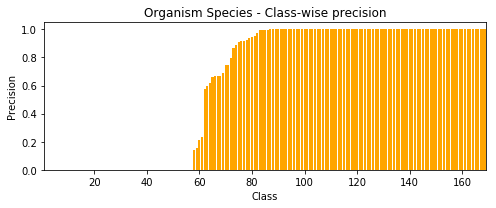

In [10]:
plt.figure(figsize=(7, 3))

x = list(range(1, len(classes) + 1))
height = sorted(precision)

plt.bar(x, height, color="orange")

plt.xlim(1, len(classes))

plt.xlabel("Class")
plt.ylabel("Precision")
plt.title("Organism Species - Class-wise precision")

plt.tight_layout()
plt.savefig("../figs/os_precision.png")

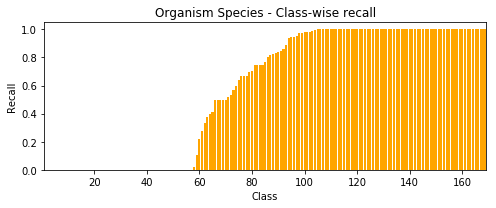

In [11]:
plt.figure(figsize=(7, 3))

x = list(range(1, len(classes) + 1))
height = sorted(recall)

plt.bar(x, height, color="orange")

plt.xlim(1, len(classes))

plt.xlabel("Class")
plt.ylabel("Recall")
plt.title("Organism Species - Class-wise recall")

plt.tight_layout()
plt.savefig("../figs/os_recall.png")

In [12]:
np.unique(precision, return_counts=True)

(array([0.        , 0.14423077, 0.15680246, 0.21333333, 0.23076923,
        0.57575758, 0.6       , 0.61797753, 0.65942029, 0.66666667,
        0.68939394, 0.75      , 0.79508197, 0.86666667, 0.88888889,
        0.90697674, 0.91666667, 0.91891892, 0.92733564, 0.93939394,
        0.94642857, 0.95652174, 0.97701149, 0.9947644 , 0.99586777,
        0.99617152, 0.99869253, 1.        ]),
 array([57,  1,  1,  1,  1,  1,  1,  1,  1,  3,  1,  2,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 83], dtype=int64))

In [13]:
np.unique(recall, return_counts=True)

(array([0.        , 0.01886792, 0.10526316, 0.2173913 , 0.27868852,
        0.33333333, 0.375     , 0.4       , 0.4092827 , 0.5       ,
        0.51666667, 0.53333333, 0.57142857, 0.59459459, 0.64197531,
        0.66666667, 0.69444444, 0.70247934, 0.75      , 0.76470588,
        0.8       , 0.81481481, 0.82352941, 0.83333333, 0.84259259,
        0.84821429, 0.85714286, 0.88888889, 0.9375    , 0.94594595,
        0.94642857, 0.95454545, 0.97222222, 0.97619048, 0.97808442,
        0.98076923, 0.9811463 , 0.98717949, 0.99880135, 1.        ]),
 array([57,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  3,  1,
         1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1, 65], dtype=int64))